

<h1> Práctica 3 - APCC. </h1>

<h3>La QFT y sumadores cuánticos.</h3>

**Ejercicio 1**. Implementar con Cirq el circuito generador de números aleatorios de la Práctica 1, simulándolo en local. Mostrar y comentar resultados.

In [11]:
import cirq
import cirq_google
import numpy as np

In [12]:
# Definimos el circuito
def random_circuit():
    q = cirq.NamedQubit('aleat')
    aleat_circuit = cirq.Circuit()
    aleat_circuit.append(cirq.H(q)) # Puerta Hadamard
    aleat_circuit.append(cirq.measure(q, key='num_aleat')) # Medicion del qubit
    return aleat_circuit

In [13]:
# Creamos circuito generador de numeros aleatorios y lo simulamos
simulator = cirq.Simulator()
circuit = random_circuit()
result = simulator.run(circuit, repetitions = 10000)
# Mostramos los resultados
print("Resultados de las mediciones del Generador de Números Aleatorios con Cirq")
print(result.histogram(key ='num_aleat'))
print(circuit)

Resultados de las mediciones del Generador de Números Aleatorios con Cirq
Counter({1: 5015, 0: 4985})
aleat: ───H───M('num_aleat')───


De la simulación, observamos que al generar una gran cantidad de números aleatorios entre 0 y 1, las apariciones de ambos se dsitribuyen equitativamente tal y como ocurría con la implementación en Qiskit ofrecida junto con la práctica 1. La programación en Cirq es, por el momento, bastante similar a Qiskit. Sin embargo, las herramientas de visualización de resultados de Qiskit son más potentes.

**Ejercicio 2**. Implementar con Cirq la QFT y la AQFT para 4 qubits. La AQFT tendrá 2 rotaciones máximo. ¿Cómo demuestras que funciona? Mostrar y comentar resultados.

In [14]:
# Definir la QFT para n qubits
def qft_circuit(n):
    circuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(n)
    for i in range(n):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i+1, n):
            circuit.append(cirq.CZ(qubits[i], qubits[j])**(1/2**(j-i)))
    return circuit

# Definir la AQFT para n qubits, con max m rotaciones (en nuestro caso, 2)
def aqft_circuit(n, m):
    circuit = cirq.Circuit()
    qubits = cirq.LineQubit.range(n)
    for i in range(n):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i+1,i+1+m):
            if j < n:
                circuit.append(cirq.CZ(qubits[i], qubits[j])**(1/2**(j-i)))
    return circuit

Para demostrar que funcionan, basta con comprobar que la implementación de la QFT es correcta, pues la AQFT no es más que una variación de nuestra implementación donde aplicamos un número prefijado de rotaciones controladas como máximo. Para ello, podemos construir un circuito con nuestra implementación, otro con el constructor de cirq y compararlos.

**Actualización**. Al final del apartado, se expone una manera más simple de demostrar que opera correctamente: aplicar la qft y su inversa a una entrada, comprobando que la salida coincida en valor con la entrada.

In [15]:
# Declaracion de parametros
n_qubits = 4
rot_aqft = 2

In [16]:
# Creamos e imprimimos nuestro circuito
qft = qft_circuit(n_qubits)
print(qft)

                  ┌───────┐   ┌────────────┐   ┌───────┐
0: ───H───@────────@───────────@───────────────────────────────────────
          │        │           │
1: ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────────
                   │           │      │         │
2: ────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────────
                               │                │          │
3: ────────────────────────────@^(1/8)──────────@^0.25─────@^0.5───H───
                  └───────┘   └────────────┘   └───────┘


In [17]:
# Creamos e imprimimos el circuito QFT de 4 qubits de cirq
qubits = cirq.LineQubit.range(4)
qft_operation = cirq.qft(*qubits, without_reverse=True)
qft_cirq = cirq.Circuit(qft_operation)
print(qft_cirq)

0: ───qft[norev]───
      │
1: ───#2───────────
      │
2: ───#3───────────
      │
3: ───#4───────────


In [18]:
try:
    np.testing.assert_allclose(cirq.unitary(qft), cirq.unitary(qft_cirq))
except:
    print("Hubo un error")

Dado que la comprobación de los valores no ha generado ningún error, asumimos que la implementación de la QFT es correcta. 

Si, además, generamos nuestro circuito de la AQFT y lo comparamos, bien sea con nuestra qft o la de cirq, dado que la diferencia en los resultados supera la tolerencia de error permitida por la comprobación de la función anterior, generará un error.

In [19]:
# Creamos e imprimimos nuestro circuito
aqft = aqft_circuit(n_qubits, rot_aqft)
print(aqft)

                  ┌───────┐           ┌───────┐
0: ───H───@────────@──────────────────────────────────────────
          │        │
1: ───────@^0.5────┼─────H────@────────@──────────────────────
                   │          │        │
2: ────────────────@^0.25─────@^0.5────┼─────H────@───────────
                                       │          │
3: ────────────────────────────────────@^0.25─────@^0.5───H───
                  └───────┘           └───────┘


In [20]:
try:
    np.testing.assert_allclose(cirq.unitary(aqft), cirq.unitary(qft_cirq))
except:
    print("Salta error por la aproximación")

Salta error por la aproximación


Por tanto, la aqft está aproximando valores. Al margen, del resultado anterior, podemos probar a simular ambas implementaciones para algunos estados iniciales y comparar los resultados.

In [26]:
import itertools

In [27]:
# Define la función para generar todas las combinaciones posibles de 0's y 1's
def generate_all_initial_states():
    # Genera todas las combinaciones posibles de 0's y 1's para 4 qubits
    combinations = list(itertools.product([0, 1], repeat=4))
    return combinations

# Generamos todas las combinaciones posibles de initial_state e inicializamos simulador
initial_states = generate_all_initial_states()
simulator = cirq.Simulator()

# Lista para almacenar los resultados
results = []

# Simula para cada combinación de initial_state
for initial_state in initial_states:
    # Simula con qft
    result_qft = simulator.simulate(qft, initial_state=initial_state)
    final_state_qft = result_qft.final_state_vector.tolist()

    # Simula con aqft
    result_aqft = simulator.simulate(aqft, initial_state=initial_state)
    final_state_aqft = result_aqft.final_state_vector.tolist()

    # Almacena los resultados en una lista de pares
    results.append((final_state_qft, final_state_aqft))

In [28]:
print(initial_states)

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)]


Ahora, results contiene los pares final_state_qft, final_state_aqft para todas las combinaciones posibles de initial_state. Mostramos visualmente los resultados, comparando la diferencia de los valores obtenidos para la qft y su aproximación.

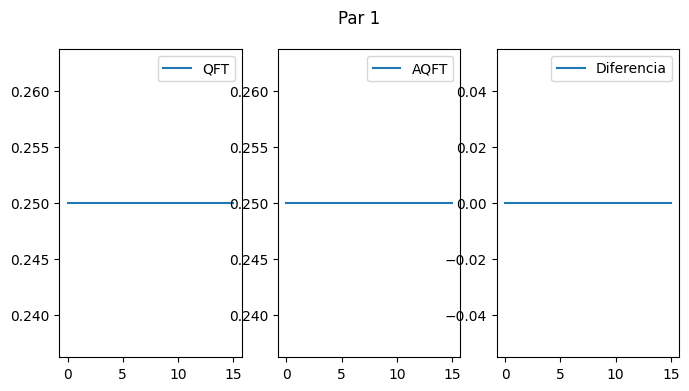

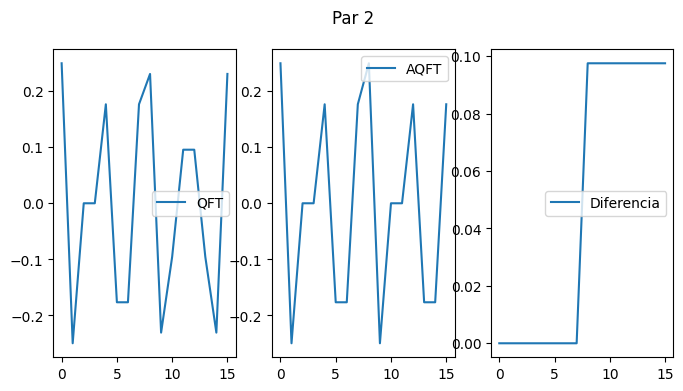

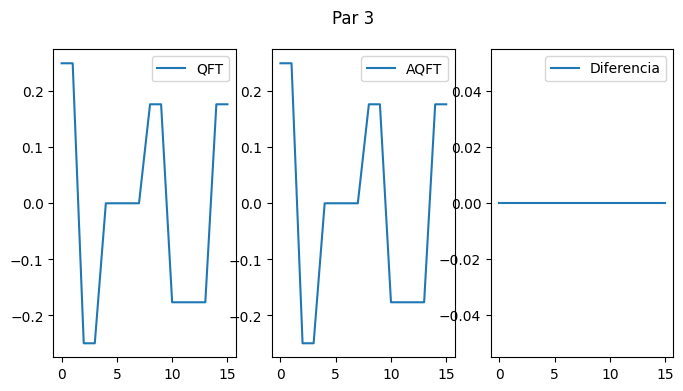

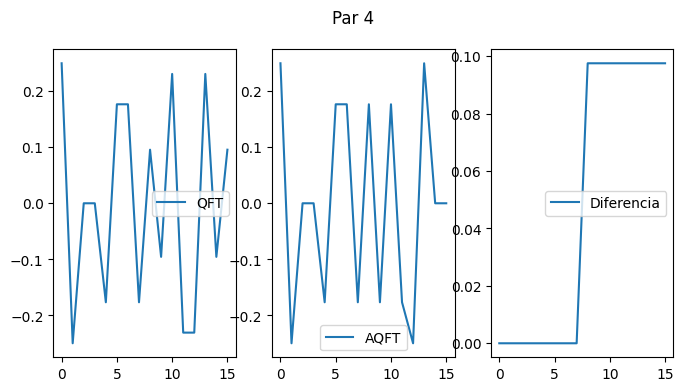

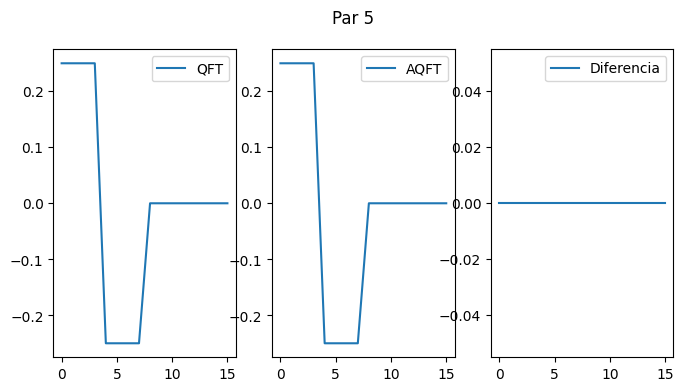

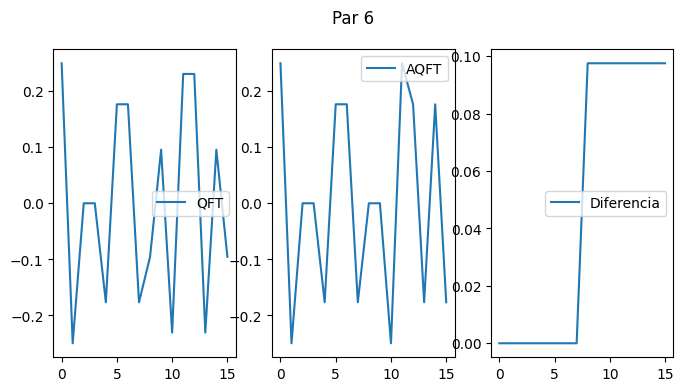

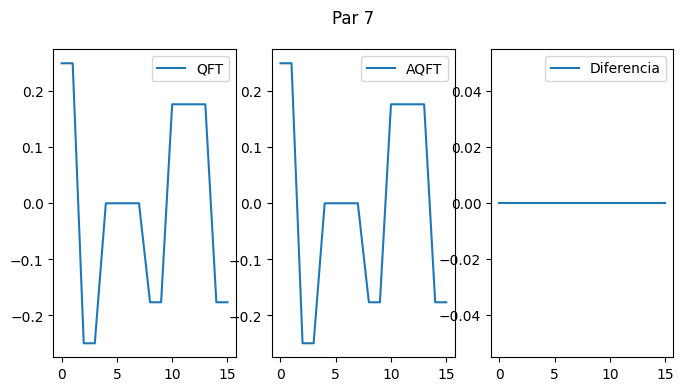

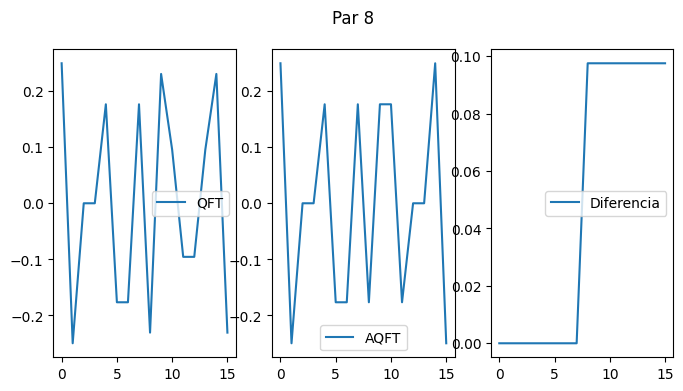

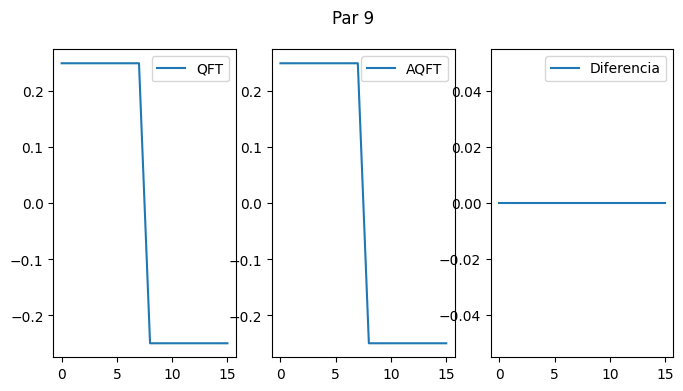

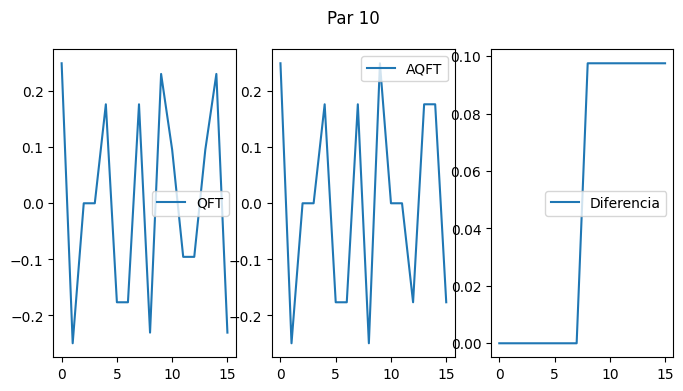

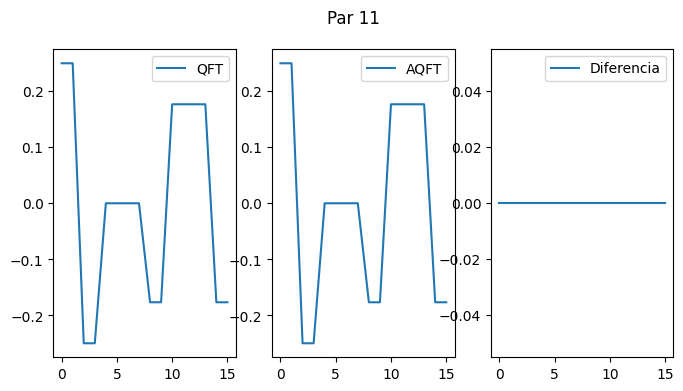

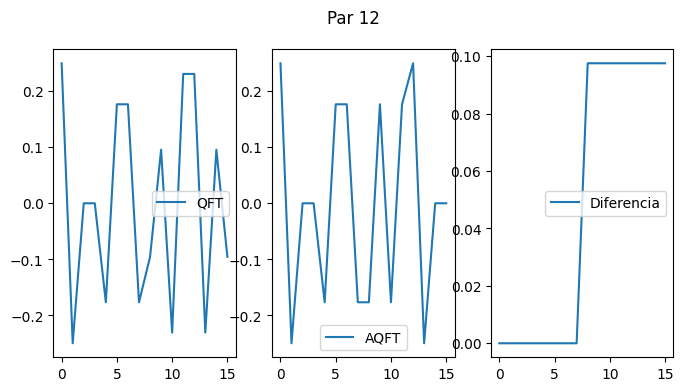

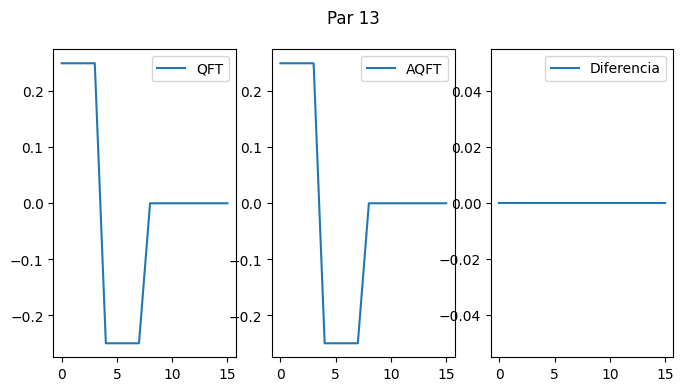

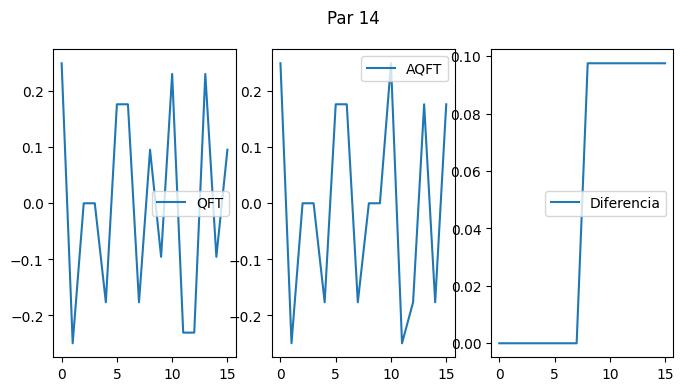

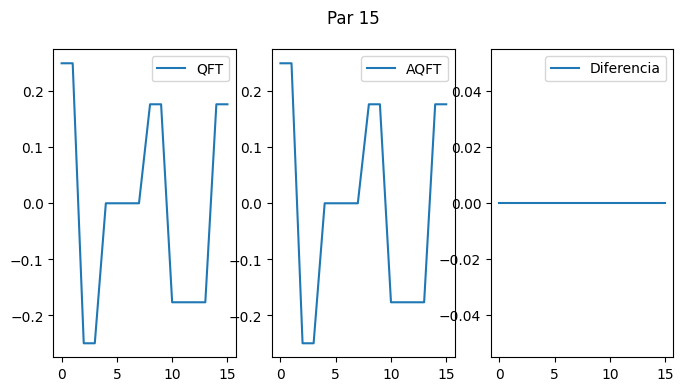

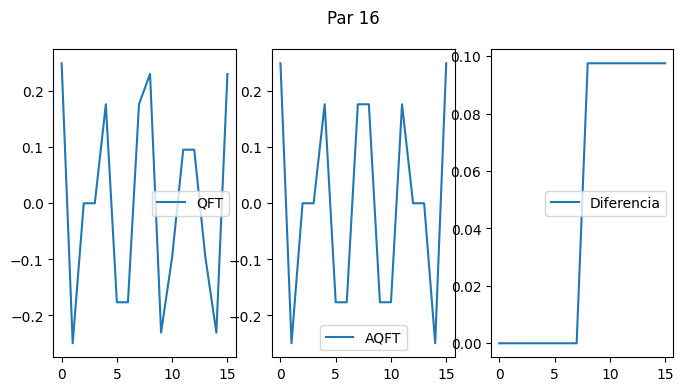

NameError: name 'ComplexWarning' is not defined

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Graficar las diferencias entre cada par
for i, (list1, list2) in enumerate(results):
    plt.figure(figsize=(8, 4))
    
    # Dibujar la primera lista
    plt.subplot(1, 3, 1)
    plt.plot(list1, label='QFT')
    plt.legend()
    
    
    # Dibujar la segunda lista
    plt.subplot(1, 3, 2)
    plt.plot(list2, label='AQFT')
    plt.legend()
    
    # Dibujar la diferencia entre las dos listas
    plt.subplot(1, 3, 3)
    plt.plot(np.abs(np.array(list1) - np.array(list2)), label='Diferencia')
    plt.legend()
    
    plt.suptitle(f'Par {i+1}')
    plt.show()

import warnings
# Ignoramos warning de complejidad, nos basta con observar el error real
warnings.filterwarnings("ignore", category=ComplexWarning)

De los resultados obtenidos observamos que las diferencias se sitúan entre 0 y 0.1 aproximadamente. Además, los pares en los que observamos que se producen estas diferencias coinciden con las parejas identificadas con números pares (par 2, par 4, ...), correspondiéndose con los estados cuyo qubit más significativo es 1 (qubit3=1). Considerando de nuevo ambos circuitos:

In [31]:
print(qft)

                  ┌───────┐   ┌────────────┐   ┌───────┐
0: ───H───@────────@───────────@───────────────────────────────────────
          │        │           │
1: ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────────
                   │           │      │         │
2: ────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────────
                               │                │          │
3: ────────────────────────────@^(1/8)──────────@^0.25─────@^0.5───H───
                  └───────┘   └────────────┘   └───────┘


In [32]:
print(aqft)

                  ┌───────┐           ┌───────┐
0: ───H───@────────@──────────────────────────────────────────
          │        │
1: ───────@^0.5────┼─────H────@────────@──────────────────────
                   │          │        │
2: ────────────────@^0.25─────@^0.5────┼─────H────@───────────
                                       │          │
3: ────────────────────────────────────@^0.25─────@^0.5───H───
                  └───────┘           └───────┘


Observamos que, dado que el número máximo de rotaciones por qubit es de dos, la única diferencia entre ambos circuitos es una rotación adicional sobre el qubit 1 controlada por el qubit 3. Es por este motivo que, en los resultados anteriores, solo observamos diferencias en los resultados cuando el qubit 3 activa la rotación de fase sobre el qubit 1 en la qft, lo que se produce cuando qubit3=1. Gracias a estos resultados, queda demostrado el correcto funcionamiento de ambos circuitos.

Por último, observemos de cerca los resultados para alguna configuración concreta:

In [33]:
# Simular el circuito QFT en un estado específico
simulator = cirq.Simulator()
result = simulator.simulate(qft, initial_state=[0, 0, 0, 1])
# Obtener el vector de amplitud resultante
final_state_1 = result.final_state_vector
# Imprimir el vector de amplitud resultante
print("Vector de amplitud después de aplicar la QFT:")
print(final_state_1)

Vector de amplitud después de aplicar la QFT:
[ 0.24999997+0.j         -0.24999997+0.j          0.        +0.24999997j
  0.        -0.24999997j  0.17677668+0.17677668j -0.17677668-0.17677668j
 -0.17677668+0.17677668j  0.17677668-0.17677668j  0.23096985+0.09567085j
 -0.23096985-0.09567085j -0.09567085+0.23096985j  0.09567085-0.23096985j
  0.09567083+0.23096985j -0.09567083-0.23096985j -0.23096985+0.09567083j
  0.23096985-0.09567083j]


In [34]:
# Simular el circuito AQFT en un estado específico
simulator = cirq.Simulator()
result = simulator.simulate(aqft, initial_state=[0, 0, 0, 1])
# Obtener el vector de amplitud resultante
final_state_2 = result.final_state_vector
# Imprimir el vector de amplitud resultante
print("Vector de amplitud después de aplicar la AQFT:")
print(final_state_2)

Vector de amplitud después de aplicar la AQFT:
[ 0.24999997+0.j         -0.24999997+0.j          0.        +0.24999997j
  0.        -0.24999997j  0.17677668+0.17677668j -0.17677668-0.17677668j
 -0.17677668+0.17677668j  0.17677668-0.17677668j  0.24999997+0.j
 -0.24999997+0.j          0.        +0.24999997j  0.        -0.24999997j
  0.17677668+0.17677668j -0.17677668-0.17677668j -0.17677668+0.17677668j
  0.17677668-0.17677668j]


In [35]:
print(abs(final_state_1 - final_state_2))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.09754515 0.09754515 0.09754515 0.09754515
 0.09754515 0.09754515 0.09754515 0.09754515]


En los datos anteriores, la j representa el valor imaginario y el valor absoluto aplica el Teorema de Pitágormas para calcular la magnitud de los valores. Se corresponde con los resultados que obtuvimos anteriormente, donde la diferencia era 0.1 aproximadamente cuando inicializábamos a 1 el qubit3.

**Importante**. Una forma más sencilla de demostrar que tanto la QFT como la AQFT funcionan consiste en probar una secuencia de qubits y comprobar que la salida es equivalente a la entrada tras aplicar la QFT y la QFT inversa (ídem para la AQFT).

In [51]:
# Inicialización de las variables --> Estado |1001>
q0, q1, q2, q3 = cirq.LineQubit.range(4)
circuit = cirq.Circuit()
circuit.append(cirq.X(q0))
circuit.append(cirq.X(q2))

In [52]:
# Crear circuito con QFT y QFT inversa
circuit.append(qft_circuit(4))
circuit.append(cirq.inverse(qft_circuit(4)))
circuit.append(cirq.measure(q0, q1, q2, q3))

In [53]:
# Mostramos resultado para entrada 1001
simulator = cirq.Simulator()
result = simulator.simulate(circuit)
print("Resultados: ", result)

Resultados:  measurements: q(0),q(1),q(2),q(3)=1010

qubits: (cirq.LineQubit(0),)
output vector: |1⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |1⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

phase:
output vector: |⟩


Repetimos el mismo procedimiento para la aqft.

In [54]:
# Inicialización de las variables --> Estado |1001>
q0, q1, q2, q3 = cirq.LineQubit.range(4)
circuit = cirq.Circuit()
circuit.append(cirq.X(q0))
circuit.append(cirq.X(q2))

# Crear circuito con AQFT y AQFT inversa
circuit.append(aqft_circuit(4,2))
circuit.append(cirq.inverse(aqft_circuit(4,2)))
circuit.append(cirq.measure(q0, q1, q2, q3))

# Mostramos resultado para entrada 1001
simulator = cirq.Simulator()
result = simulator.simulate(circuit)
print("Resultados: ", result)

Resultados:  measurements: q(0),q(1),q(2),q(3)=1010

qubits: (cirq.LineQubit(0),)
output vector: |1⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |1⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

phase:
output vector: |⟩


**Ejercicio 3**. Implementar con Cirq el sumador de Draper para operandos de entrada de 4 qubits con la QFT y la AQFT. La AQFT tendrá 2 rotaciones máximo. Mostrar y comentar resultados.

Para la implementación del sumador de Draper, refactorizaremos un poco las definiciones de qft_circuit y aqft_circuit de forma que los qubits se generen antes de su invocación y se indiquen como parámetros de entrada.

In [55]:
# Definir la QFT para n qubits
def qft_circuit(n, qubits):
    circuit = cirq.Circuit()
    for i in range(n):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i+1, n):
            circuit.append(cirq.CZ(qubits[i], qubits[j])**(1/2**(j-i)))
    return circuit

# Definir la AQFT para n qubits, con max m rotaciones (en nuestro caso, 2)
def aqft_circuit(n, m, qubits):
    circuit = cirq.Circuit()
    for i in range(n):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i+1,i+1+m):
            if j < n:
                circuit.append(cirq.CZ(qubits[i], qubits[j])**(1/2**(j-i)))
    return circuit

El sumador Draper consiste en aplicar, en orden, la QFT al operando A, la suma en el dominio de la fase y la QFT inversa sobre el resultado, que se almacena en el operando A debido a la phase kickback.

La suma en el dominio de la fase se realiza mediante rotaciones controladas, siguiendo la siguiente regla: dados A = An−1An−2...A1A0 y B = Bn−1Bn−2...B1B0, el qubit Bj controla una rotación sobre el qubit Ai con un ángulo de π/2^(i−j), ∀j, 0 ≤ j ≤ i.

Implementamos un sumador Draper genérico, con el que emplearemos operandos de 4 qubits.

In [56]:
# Definimos el tamaño de los operandos
tamOp = 4
# Crear qubits de entrada
a = [cirq.GridQubit(0, i) for i in range(tamOp)]
b = [cirq.GridQubit(1, i) for i in range(tamOp)]
# Parametro que indica si usar qft o aqft (si false --> qft; si true --> aqft)
aprox = False

In [57]:
# Definimos la suma en el dominio de la fase:
def suma_fase(a, b):
    circuit = cirq.Circuit()
    for i in range(len(a)):
        for j in range(len(b)):
            if j >= i:
                # Suma controlada modular
                circuit.append(cirq.CZ(a[i], b[j])**(1/2**((len(a) - i) - (len(b) - j))))
    return circuit

Como paso previo, imprimimos la suma en el dominio de la fase para comprobar que las operaciones se realizan siguiendo el esquema mencionado anteriormente. 

In [58]:
# Construir el circuito del sumador de Draper
suma = suma_fase(a, b)
# Representacion del circuito
print("Suma en el dominio de la fase:")
print(suma)

Suma en el dominio de la fase:
                       ┌───────┐   ┌────────────┐   ┌───────┐
(0, 0): ───@───@────────@───────────@───────────────────────────────────────
           │   │        │           │
(0, 1): ───┼───┼────────┼─────@─────┼──────@─────────@──────────────────────
           │   │        │     │     │      │         │
(0, 2): ───┼───┼────────┼─────┼─────┼──────┼─────────┼─────@────@───────────
           │   │        │     │     │      │         │     │    │
(0, 3): ───┼───┼────────┼─────┼─────┼──────┼─────────┼─────┼────┼───────@───
           │   │        │     │     │      │         │     │    │       │
(1, 0): ───@───┼────────┼─────┼─────┼──────┼─────────┼─────┼────┼───────┼───
               │        │     │     │      │         │     │    │       │
(1, 1): ───────@^0.5────┼─────@─────┼──────┼─────────┼─────┼────┼───────┼───
                        │           │      │         │     │    │       │
(1, 2): ────────────────@^0.25──────┼──────@^0.5─────┼─────@────

Sabiendo que tanto la suma en el dominio de la fase como la QFT (y la AQFT) están bien implementadas, creamos un circuito que las aplique en orden, siguiendo el protocolo.

In [59]:
# Función para construir el circuito del sumador de Draper
def draper_adder(a, b, aprox):
    # Comprobamos que el tamaño de los operandos sea el mismo
    assert(len(a) == len(b))
    circuit = cirq.Circuit()
    
    # Implementación de la QFT sobre el primer operando
    if aprox:
        circuit.append(aqft_circuit(len(a), rot_aqft, a))
    else:
        circuit.append(qft_circuit(len(a), a))
        
    # Suma en el dominio de la fase
    circuit.append(suma_fase(a,b))

    # Implementación de la QFT inversa sobre el segundo operando
    if aprox:
        circuit.append(cirq.inverse(aqft_circuit(len(a), rot_aqft, a)))
    else:
        circuit.append(cirq.inverse(qft_circuit(len(a), a)))

    return circuit

In [60]:
# Construir el circuito del sumador de Draper
draper_qft = draper_adder(a, b, aprox)
# Representacion del circuito
print("Circuito del sumador de Draper con QFT:")
print(draper_qft)

Circuito del sumador de Draper con QFT:
                       ┌───────┐   ┌────────────┐   ┌───────┐                           ┌───────┐   ┌────────────┐   ┌───────┐                            ┌────────┐   ┌──────────────┐   ┌────────┐
(0, 0): ───H───@────────@───────────@───────────────────────────────────────@───@────────@───────────@──────────────────────────────────────────────────────────────────@──────────────────@───────────@────────H───
               │        │           │                                       │   │        │           │                                                                  │                  │           │
(0, 1): ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────────┼───┼────────┼─────@─────┼──────@─────────@────────────────────────────────────@────────────┼───────@──────────┼──────H────@^-0.5───────
                        │           │      │         │                      │   │        │     │     │      │         │                 

Dado el tamaño del circuito, la impresión estándar de circuitos en Cirq no permite visualizar correctamente las operaciones realizadas sobre los qubits en orden. Sin embargo, podemos emplear una función de representación alternativa: SVG.

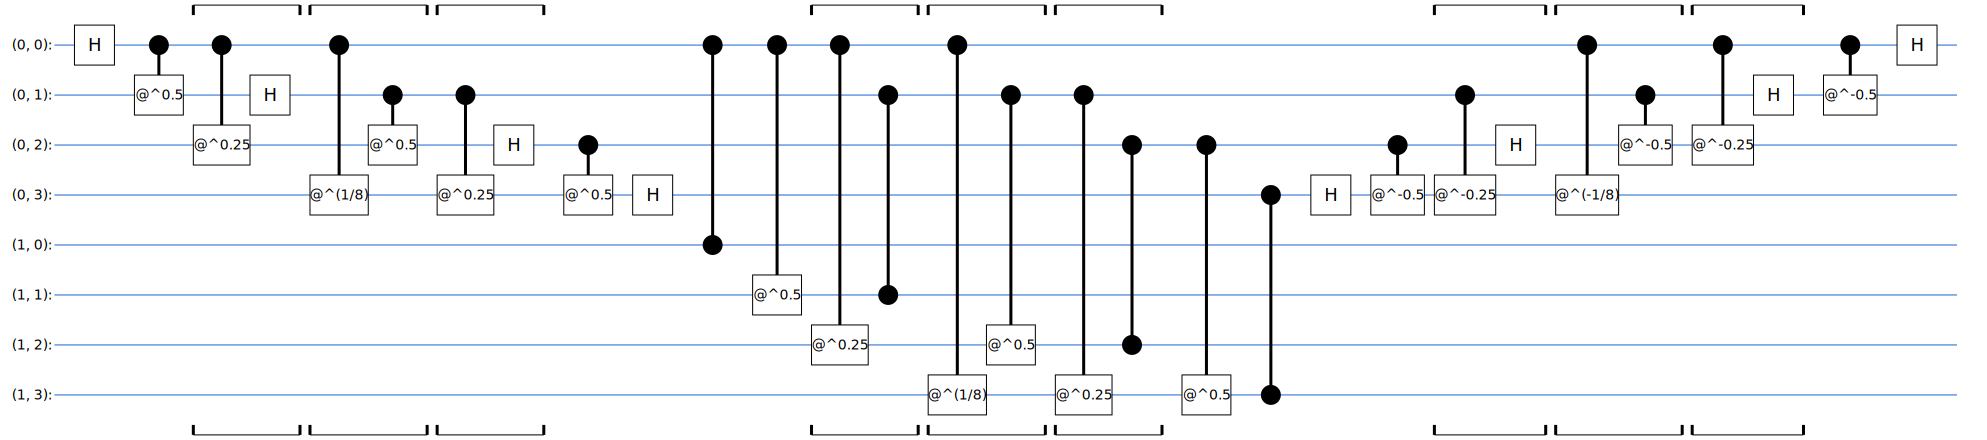

In [61]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(draper_qft)

Comprobemos que funciona. En primer lugar, añadiremos medidas a la función anterior para evaluar los resultados y crearemos un algoritmo que genere estados iniciales para los qubits en {0, 1}.

In [103]:
# Función para construir el circuito del sumador de Draper
def draper_adder_test(a, b, ini_states, aprox):
    # Comprobamos que el tamaño de los operandos sea el mismo
    circuit = cirq.Circuit()

    i = 0
    for qubit in list(ini_states):
        if qubit == 1:
            if i < len(a):
                circuit.append(cirq.X(a[i]))
            else:
                circuit.append(cirq.X(b[i-len(a)]))
        i += 1
    
    # Implementación de la QFT sobre el primer operando
    if aprox:
        circuit.append(aqft_circuit(len(a), rot_aqft, a))
    else:
        circuit.append(qft_circuit(len(a), a))
        
    # Suma en el dominio de la fase
    circuit.append(suma_fase(a,b))

    # Implementación de la QFT inversa sobre el segundo operando
    if aprox:
        circuit.append(cirq.inverse(aqft_circuit(len(a), rot_aqft, a)))
    else:
        circuit.append(cirq.inverse(qft_circuit(len(a), a)))

    # Mediciones añadidas
    circuit.append([cirq.measure(qubit) for qubit in a])
    circuit.append([cirq.measure(qubit) for qubit in b])
    return circuit

In [104]:
from itertools import product
# Creamos los estados iniciales
initial_states = generate_all_initial_states()
combinaciones = list(product(initial_states, initial_states))

In [115]:
# Inicializamos el simulador
simulator = cirq.Simulator()
# Inicializamos los qubits
qubits = cirq.LineQubit.range(8)

# Lista para almacenar los resultados
results = []
i = 0
# Simula para cada combinacion de operandos obtenidos en la celda anterior
for operandos in combinaciones:
    # Simula con qft
    result_sum_qft = simulator.run(draper_adder_test(qubits[:4], qubits[-4:], operandos[0] + operandos[1], False))
    
    # Simula con aqft
    result_sum_aqft = simulator.run(draper_adder_test(qubits[:4], qubits[-4:], operandos[0] + operandos[1], True))
    
    # Almacena los resultados en una lista de pares
    print("Operandos: ", operandos[0], operandos[1]) 
    print("Resultado en qft:\n", result_sum_qft)
    print("Resultado en aqft:\n", result_sum_aqft)
    print("----------------------------------------")
    i += 1

Operandos:  (0, 0, 0, 0) (0, 0, 0, 0)
Resultado en qft:
 q(0)=0
q(1)=0
q(2)=0
q(3)=0
q(4)=0
q(5)=0
q(6)=0
q(7)=0
Resultado en aqft:
 q(0)=0
q(1)=0
q(2)=0
q(3)=0
q(4)=0
q(5)=0
q(6)=0
q(7)=0
----------------------------------------
Operandos:  (0, 0, 0, 0) (0, 0, 0, 1)
Resultado en qft:
 q(0)=0
q(1)=0
q(2)=0
q(3)=1
q(4)=0
q(5)=0
q(6)=0
q(7)=1
Resultado en aqft:
 q(0)=0
q(1)=0
q(2)=0
q(3)=1
q(4)=0
q(5)=0
q(6)=0
q(7)=1
----------------------------------------
Operandos:  (0, 0, 0, 0) (0, 0, 1, 0)
Resultado en qft:
 q(0)=0
q(1)=0
q(2)=1
q(3)=0
q(4)=0
q(5)=0
q(6)=1
q(7)=0
Resultado en aqft:
 q(0)=0
q(1)=0
q(2)=1
q(3)=0
q(4)=0
q(5)=0
q(6)=1
q(7)=0
----------------------------------------
Operandos:  (0, 0, 0, 0) (0, 0, 1, 1)
Resultado en qft:
 q(0)=0
q(1)=0
q(2)=1
q(3)=1
q(4)=0
q(5)=0
q(6)=1
q(7)=1
Resultado en aqft:
 q(0)=0
q(1)=0
q(2)=1
q(3)=1
q(4)=0
q(5)=0
q(6)=1
q(7)=1
----------------------------------------
Operandos:  (0, 0, 0, 0) (0, 1, 0, 0)
Resultado en qft:
 q(0)=0
q(1)=1
q(2)=0
q(

Tal y como puede observarse en los resultados obtenidos, obtenemos los mismos valores de salida tanto para la QFT como para la AQFT en simulación, todos ellos correctos. Al haber implementado el sumador sin un qubit adicional (ni bit de registro extra), se produce desbordamiento en algunas sumas donde se excede el valor de representación. No supone un problema en la demostración del funcionamiento del sumador (podemos olvidarnos del valor del quinto qubit necesario).

**Ejercicio 4**. Repetir el Ejercicio 3 codificándolo con Qiskit, realizando ejecuciones en backends reales de IBM, IonQ y/o Quantinuum.

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import(QuantumCircuit, transpile, providers, QuantumRegister, ClassicalRegister)
from qiskit_aer import AerSimulator

# Save an IBM Quantum account and set it as your default account.
service = QiskitRuntimeService(channel="ibm_quantum", token="")
backends = service.backends()

print("Backends disponibles: ")
for backend in backends:
    print(backend)

Backends disponibles: 
<IBMBackend('simulator_extended_stabilizer')>
<IBMBackend('simulator_stabilizer')>
<IBMBackend('ibm_kyoto')>
<IBMBackend('ibm_osaka')>
<IBMBackend('ibm_sherbrooke')>
<IBMBackend('ibmq_qasm_simulator')>
<IBMBackend('simulator_mps')>
<IBMBackend('simulator_statevector')>
<IBMBackend('ibm_brisbane')>


Para facilitar el desarrollo, implementaremos los circuitos correspondientes a cada una de las partes por separado y, al final, las uniremos en un único circuito.

In [3]:
# Importamos todo lo necesario
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from numpy import pi, random

Definimos la función que genera la qft de length(qubits) e imprimimos el circuito.

In [4]:
def qft_qiskit(qubits):
    circuito = QuantumCircuit(len(qubits))
    for j in range(len(qubits)):
        circuito.h(qubits[j])
        for k in range(j+1, len(qubits)):
            circuito.cp(pi/float(2**(k-j)), qubits[k], qubits[j])
        circuito.barrier()
    return circuito

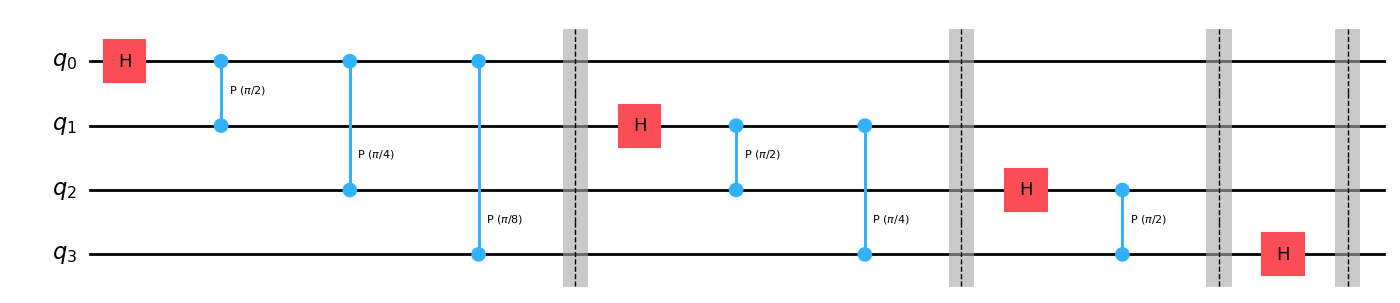

In [5]:
qubits = [0, 1, 2, 3]
circuito_qft = qft_qiskit(qubits)
circuito_qft.draw('mpl')

Definimos la función que genera la aqft de length(qubits) con n rotaciones como máximo e imprimimos el circuito

In [6]:
def aqft_qiskit(n, qubits):
    circuito = QuantumCircuit(len(qubits))
    for j in range(len(qubits)):
        circuito.h(qubits[j])
        for k in range(j+1, j+1+n):
            if k < len(qubits):
                circuito.cp(pi/float(2**(k-j)), qubits[k], qubits[j])
        circuito.barrier()
    return circuito

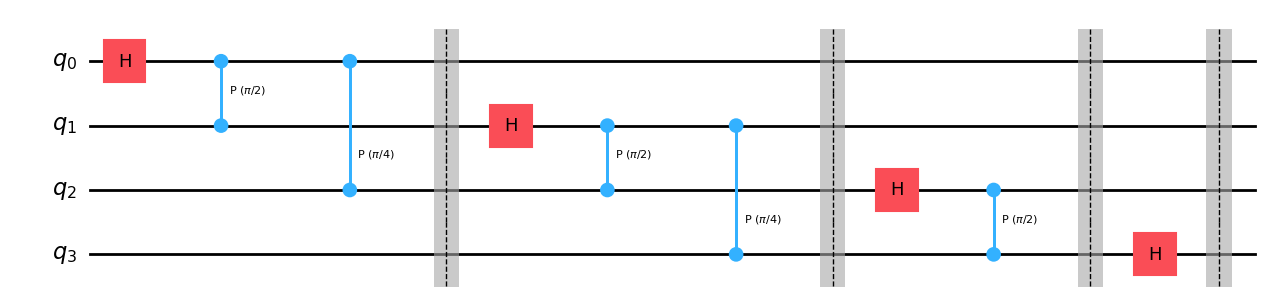

In [7]:
qubits = [0, 1, 2, 3]
rot = 2
circuito_aqft = aqft_qiskit(rot, qubits)
circuito_aqft.draw('mpl')

Definimos la función que genera la suma en el dominio de la fase para el sumador Draper e imprimimos el circuito.

In [33]:
# Definimos la suma en el dominio de la fase para operandos a y b:
def suma_fase_qiskit(qubits):
    circuito = QuantumCircuit(2*len(qubits))
    for i in range(len(qubits)):
        for j in range(len(qubits) - i):
            circuito.cp(2*pi/2**(j+1),control_qubit=len(qubits)-i-1-j,target_qubit=2*len(qubits)-i-1)
        circuito.barrier()
    return circuito

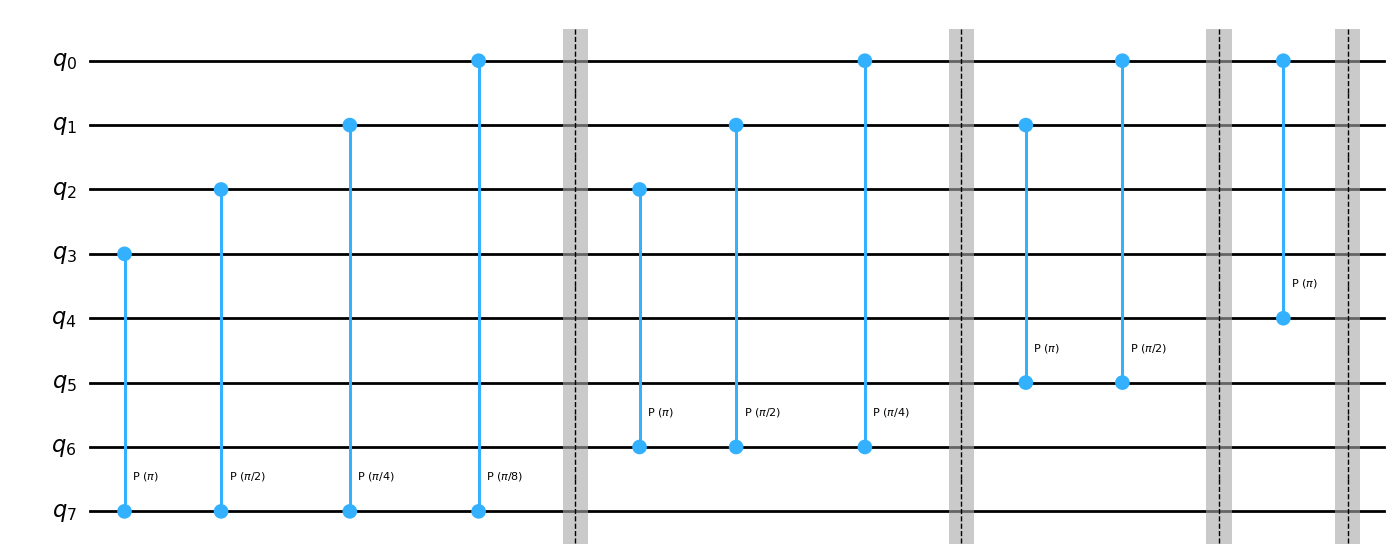

In [34]:
suma_fase_q = suma_fase_qiskit(qubits)
suma_fase_q.draw('mpl')

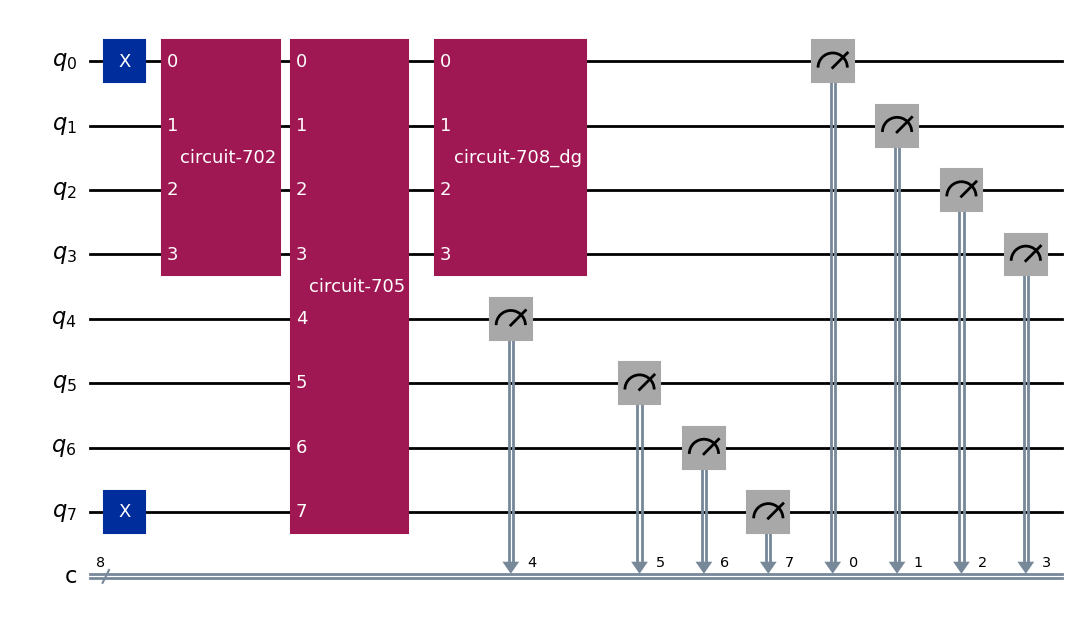

In [60]:
# Definimos el circuito
sumador = QuantumCircuit(8,8)
sumador.x(0)
sumador.x(7)
sumador.append(qft_qiskit([0,1,2,3]), sumador.qubits[:4])
sumador.append(suma_fase_qiskit([0,1,2,3]), sumador.qubits[:8])
sumador.append(qft_qiskit([0,1,2,3]).inverse(), sumador.qubits[:4])
sumador.measure([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])
sumador.draw('mpl')

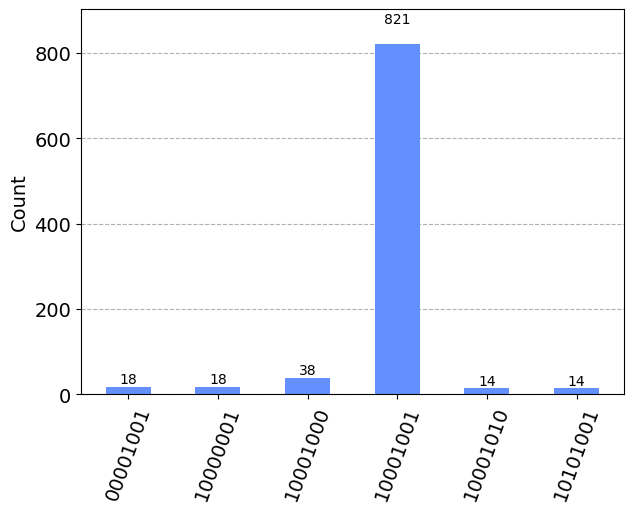

In [67]:
from qiskit.providers.fake_provider import GenericBackendV2

# Aplicamos simulación con ruido
simulator = GenericBackendV2(num_qubits=8)
sumador = transpile(sumador, simulator)
job = simulator.run(sumador, shots=1000)
counts = job.result().get_counts(sumador)

# Mostramos resultados
# Ordenamos y tomamos solo los seis elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:6])
# Utiliza plot_histogram con los seis valores más repetidos
plot_histogram(top_counts)
#plot_histogram(counts)

De esta forma, en el histograma observamos que la salida se corresponde con la suma de A y B para el operador A (primeros 4 qubits, leídos de arriba a abajo y de derecha a izquierda), mientras que el operando B mantiene el valor de la entrada.

Veamos, a continuación, la implementación para realizar n pruebas con diferentes operandos. Primero, generaremos una lista de operandos que randomizaremos para, después, iterar n veces sobre ella, mostrando operandos y resultados para comprobar que las sumas se realizan correctamente.

In [68]:
from itertools import product
operandos = list(product(product([0, 1], repeat=4), repeat=2))

((0, 0, 0, 0), (0, 0, 0, 0))
((0, 0, 0, 0), (0, 0, 0, 1))
((0, 0, 0, 0), (0, 0, 1, 0))
((0, 0, 0, 0), (0, 0, 1, 1))
((0, 0, 0, 0), (0, 1, 0, 0))
((0, 0, 0, 0), (0, 1, 0, 1))
((0, 0, 0, 0), (0, 1, 1, 0))
((0, 0, 0, 0), (0, 1, 1, 1))
((0, 0, 0, 0), (1, 0, 0, 0))
((0, 0, 0, 0), (1, 0, 0, 1))
((0, 0, 0, 0), (1, 0, 1, 0))
((0, 0, 0, 0), (1, 0, 1, 1))
((0, 0, 0, 0), (1, 1, 0, 0))
((0, 0, 0, 0), (1, 1, 0, 1))
((0, 0, 0, 0), (1, 1, 1, 0))
((0, 0, 0, 0), (1, 1, 1, 1))
((0, 0, 0, 1), (0, 0, 0, 0))
((0, 0, 0, 1), (0, 0, 0, 1))
((0, 0, 0, 1), (0, 0, 1, 0))
((0, 0, 0, 1), (0, 0, 1, 1))
((0, 0, 0, 1), (0, 1, 0, 0))
((0, 0, 0, 1), (0, 1, 0, 1))
((0, 0, 0, 1), (0, 1, 1, 0))
((0, 0, 0, 1), (0, 1, 1, 1))
((0, 0, 0, 1), (1, 0, 0, 0))
((0, 0, 0, 1), (1, 0, 0, 1))
((0, 0, 0, 1), (1, 0, 1, 0))
((0, 0, 0, 1), (1, 0, 1, 1))
((0, 0, 0, 1), (1, 1, 0, 0))
((0, 0, 0, 1), (1, 1, 0, 1))
((0, 0, 0, 1), (1, 1, 1, 0))
((0, 0, 0, 1), (1, 1, 1, 1))
((0, 0, 1, 0), (0, 0, 0, 0))
((0, 0, 1, 0), (0, 0, 0, 1))
((0, 0, 1, 0),

In [74]:
import random
# Randomizamos la lista
random.shuffle(operandos)

In [76]:
# Inicializamos el simulador
simulator = service.get_backend("ibmq_qasm_simulator")

# Lista para almacenar los resultados
results = []
j = 0
# Simula para cada combinacion de operandos obtenidos en la celda anterior
for operando in operandos:
    # Creamos el circuito
    sumador_test = QuantumCircuit(8,8)
    # Inicialización operando 0
    for i, valor_qubit in enumerate(operando[0]):
        if valor_qubit == 1:
            sumador_test.x(i)

     # Inicialización operando 1
    for i, valor_qubit in enumerate(operando[1]):
        if valor_qubit == 1:
            sumador_test.x(i+4)

    # Aplicamos el protocolo para la suma
    sumador_test.append(qft_qiskit([0,1,2,3]), sumador_test.qubits[:4])
    sumador_test.append(suma_fase_qiskit([0,1,2,3]), sumador_test.qubits[:8])
    sumador_test.append(qft_qiskit([0,1,2,3]).inverse(), sumador_test.qubits[:4])
    sumador_test.measure([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])

    # Ejecutamos
    sumador_test = transpile(sumador_test, simulator)
    job = simulator.run(sumador_test)
    result_sum = job.result().get_counts(sumador_test)

    # Almacena los resultados en una lista de pares
    print("Operandos: ", operando[0], operando[1]) 
    print("Resultado: ", result_sum)
    print("-----------------------------------------")
    j += 1

    # Detenemos tras 15 ejecuciones
    if j == 15:
        break

Operandos:  (1, 0, 0, 0) (1, 1, 0, 0)
Resultado:  {'00110010': 4000}
-----------------------------------------
Operandos:  (1, 1, 1, 0) (0, 1, 1, 0)
Resultado:  {'01100010': 4000}
-----------------------------------------
Operandos:  (0, 1, 1, 0) (1, 0, 1, 0)
Resultado:  {'01010000': 4000}
-----------------------------------------
Operandos:  (1, 0, 1, 1) (0, 0, 0, 1)
Resultado:  {'10000011': 4000}
-----------------------------------------
Operandos:  (0, 1, 1, 1) (1, 1, 0, 0)
Resultado:  {'00111100': 4000}
-----------------------------------------
Operandos:  (0, 0, 0, 0) (1, 0, 0, 0)
Resultado:  {'00010001': 4000}
-----------------------------------------
Operandos:  (0, 1, 0, 1) (0, 1, 1, 1)
Resultado:  {'11100011': 4000}
-----------------------------------------
Operandos:  (1, 0, 0, 1) (0, 1, 0, 1)
Resultado:  {'10100111': 4000}
-----------------------------------------
Operandos:  (1, 0, 1, 1) (0, 1, 0, 0)
Resultado:  {'00101111': 4000}
-----------------------------------------
O

Por la implementación, la lectura de bits se realiza de derecha a izquierda, de la siguiente forma: sea una secuencia "*Resultado*" tal que q7q6q5q4q3q2q1q0, el operando A se corresponde con los qubits q3q2q1q0 y el operando B con q7q6q5q4. Pero, además, cada operando de 4 bits en "*Resultado*" debe ser leído de derecha a izquierda en lugar de izquierda a derecha.

Teniendo en cuenta estas consideraciones, los resultados son consistentes teniendo en cuenta que no se ha implementado el bit de acarreo para sumas cuyo resultado excede la capacidad de representación con 4 bits. 

Para la ejecución sobre **backends reales**, dado que la realización de numerosas pruebas consume muchos recursos, tomaremos dos pares de operandos al azar sobre los que realizaremos la suma.

In [80]:
primer_par = random.randint(1, 256)
print(operandos[primer_par])

((0, 1, 1, 1), (0, 0, 1, 0))


Ejecución sobre el backend IBM_OSAKA.

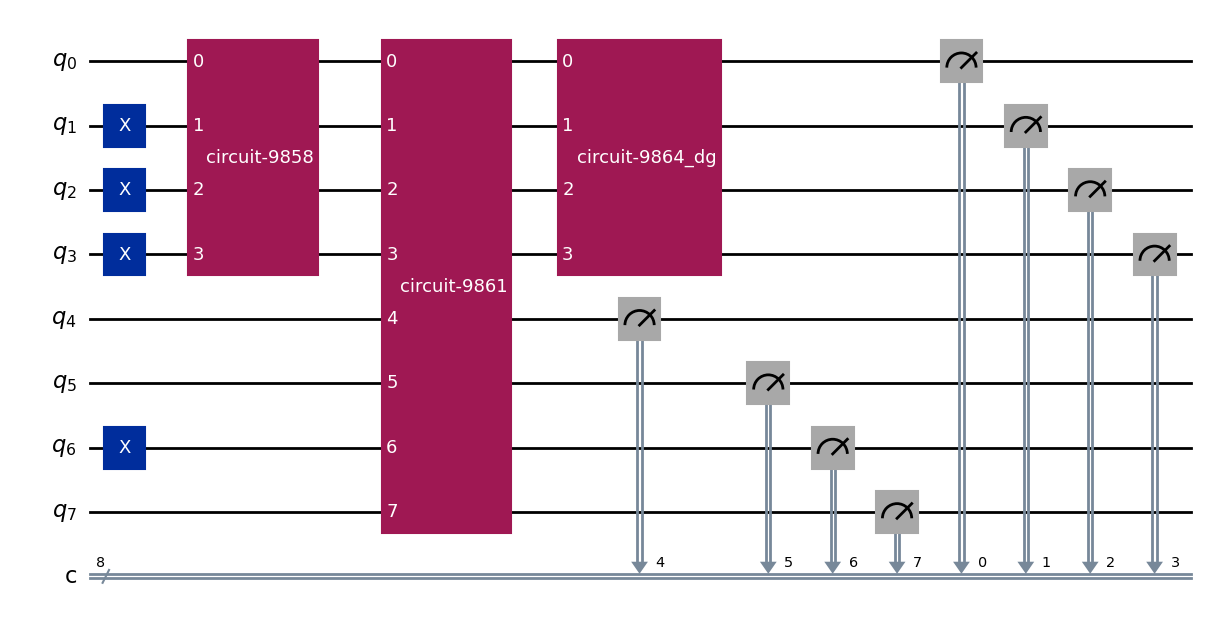

In [101]:
# Creamos el circuito para el primer par de operandos con QFT
sumador_qft = QuantumCircuit(8,8)
# Inicialización operandos
sumador_qft.x(1)
sumador_qft.x(2)
sumador_qft.x(3)
sumador_qft.x(6)
# Aplicamos el protocolo para la suma
sumador_qft.append(qft_qiskit([0,1,2,3]), sumador_qft.qubits[:4])
sumador_qft.append(suma_fase_qiskit([0,1,2,3]), sumador_qft.qubits[:8])
sumador_qft.append(qft_qiskit([0,1,2,3]).inverse(), sumador_qft.qubits[:4])
sumador_qft.measure([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])
sumador_qft.draw('mpl')

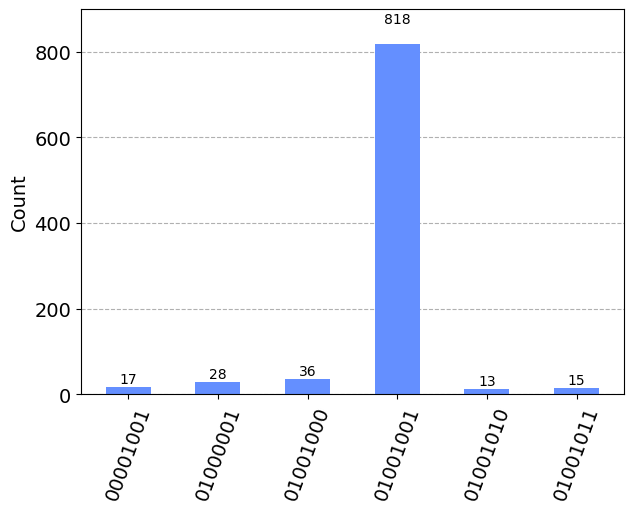

In [91]:
# En simulación con ruido
simulator = GenericBackendV2(num_qubits=8)
sumador = transpile(sumador_qft, simulator)
job = simulator.run(sumador, shots=1000)
counts = job.result().get_counts(sumador)

# Mostramos resultados
# Ordenamos y tomamos solo los seis elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:6])
# Utiliza plot_histogram con los seis valores más repetidos
plot_histogram(top_counts)

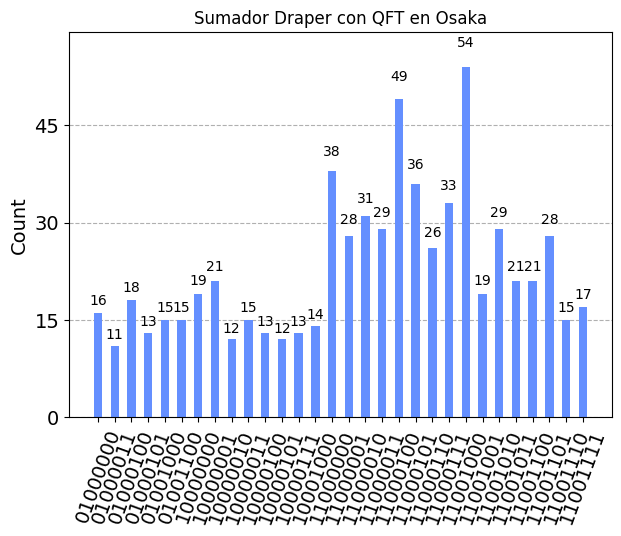

In [94]:
# En computador cuántico real
backend = service.get_backend('ibm_osaka')
sumador_qft = transpile(sumador_qft, backend)
job = backend.run(sumador_qft, shots=1000)
counts = job.result().get_counts(sumador_qft)

# Mostramos resultados
# Ordenamos y tomamos solo los elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:30])
# Utiliza plot_histogram con los valores más repetidos
plot_histogram(top_counts, title = "Sumador Draper con QFT en Osaka")

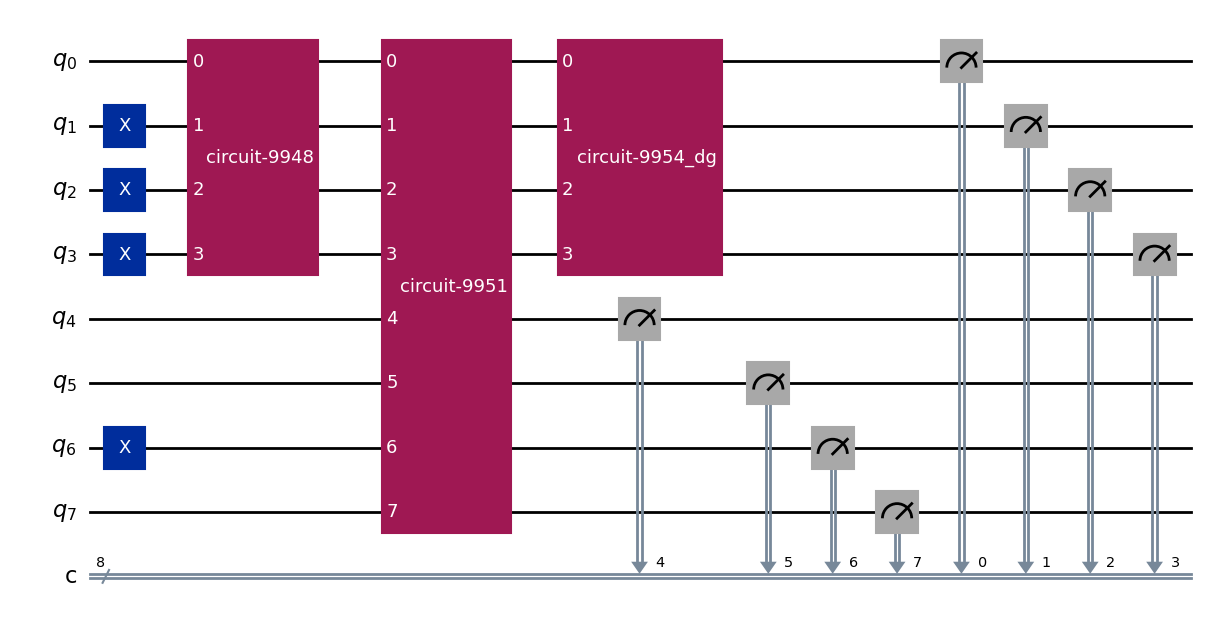

In [103]:
# Creamos el circuito para el primer par de operandos con AQFT
sumador_aqft = QuantumCircuit(8,8)
# Inicialización operandos
sumador_aqft.x(1)
sumador_aqft.x(2)
sumador_aqft.x(3)
sumador_aqft.x(6)
# Aplicamos el protocolo para la suma
sumador_aqft.append(aqft_qiskit(2, [0,1,2,3]), sumador_aqft.qubits[:4])
sumador_aqft.append(suma_fase_qiskit([0,1,2,3]), sumador_aqft.qubits[:8])
sumador_aqft.append(aqft_qiskit(2, [0,1,2,3]).inverse(), sumador_aqft.qubits[:4])
sumador_aqft.measure([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])
sumador_aqft.draw('mpl')

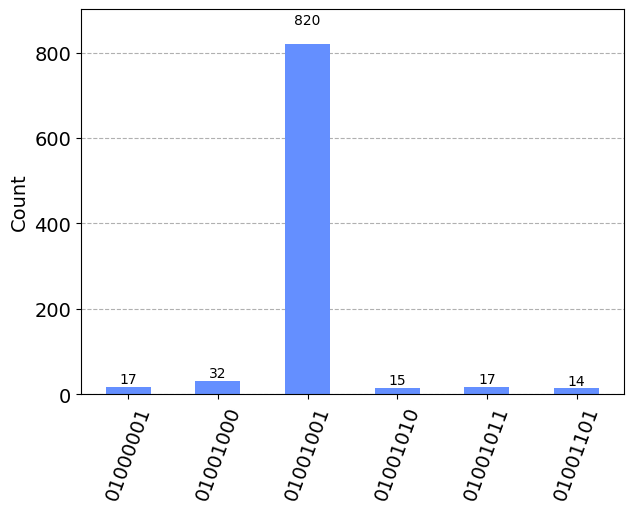

In [97]:
# En simulación con ruido
simulator = GenericBackendV2(num_qubits=8)
sumador = transpile(sumador_aqft, simulator)
job = simulator.run(sumador, shots=1000)
counts = job.result().get_counts(sumador)

# Mostramos resultados
# Ordenamos y tomamos solo los seis elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:6])
# Utiliza plot_histogram con los seis valores más repetidos
plot_histogram(top_counts)

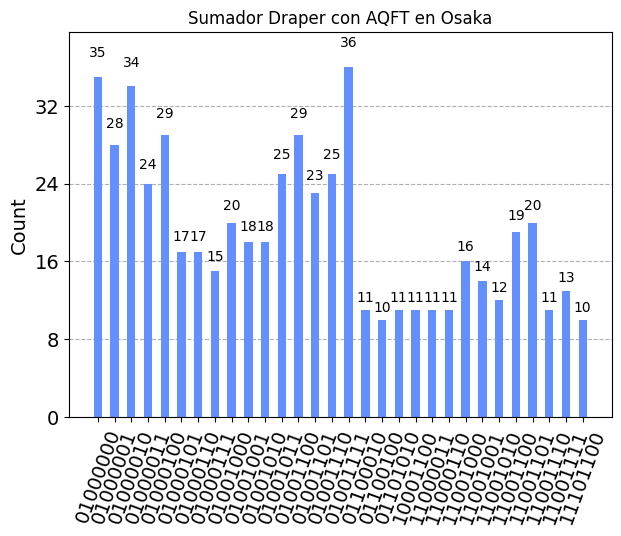

In [100]:
# En computador cuántico real
backend = service.get_backend('ibm_osaka')
sumador_aqft = transpile(sumador_aqft, backend)
job = backend.run(sumador_aqft, shots=1000)
counts = job.result().get_counts(sumador_aqft)

# Mostramos resultados
# Ordenamos y tomamos solo los elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:30])
# Utiliza plot_histogram con los valores más repetidos
plot_histogram(top_counts, title = "Sumador Draper con AQFT en Osaka")

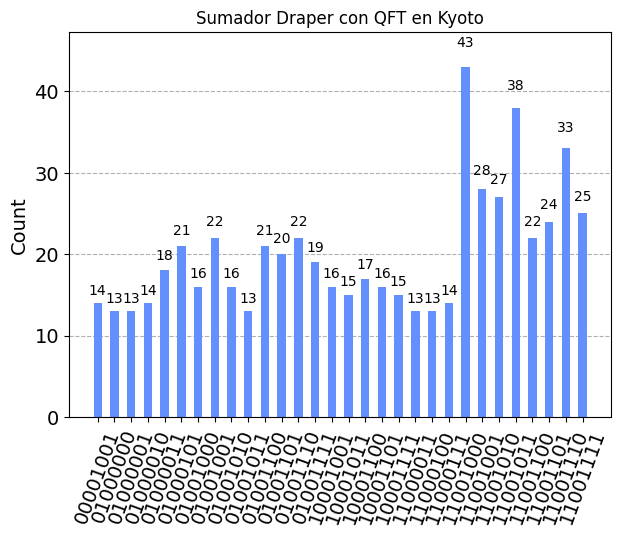

In [102]:
# En computador cuántico real
backend = service.get_backend('ibm_kyoto')
sumador_qft = transpile(sumador_qft, backend)
job = backend.run(sumador_qft, shots=1000)
counts = job.result().get_counts(sumador_qft)

# Mostramos resultados
# Ordenamos y tomamos solo los elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:30])
# Utiliza plot_histogram con los valores más repetidos
plot_histogram(top_counts, title = "Sumador Draper con QFT en Kyoto")

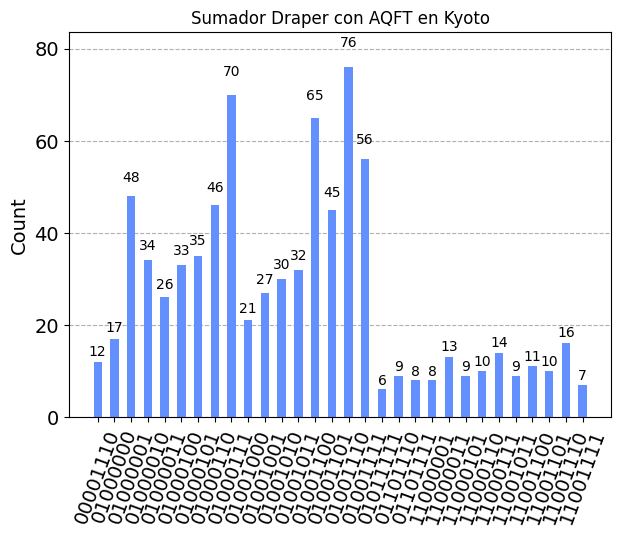

In [104]:
# En computador cuántico real
backend = service.get_backend('ibm_kyoto')
sumador_aqft = transpile(sumador_aqft, backend)
job = backend.run(sumador_aqft, shots=1000)
counts = job.result().get_counts(sumador_aqft)

# Mostramos resultados
# Ordenamos y tomamos solo los elementos más repetidos (mejor visualización)
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
top_counts = dict(list(counts.items())[:30])
# Utiliza plot_histogram con los valores más repetidos
plot_histogram(top_counts, title = "Sumador Draper con AQFT en Kyoto")

Observamos como en simulación con ruido obtenemos fácilmente los resultados deseados, pero al momento de ejecutar en backends reales necesitamos mostrar una buena cantidad de resultados para que aparezca el esperado. En Osaka, ni siquiera se encuentra entre los 30 con mayores repeticiones.